Importing all necessary libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import seaborn as sns
import theano

az.style.use('arviz-darkgrid')

Loading and exploring data.

In [ ]:
df = pd.read_csv("WineQT.csv", dtype={'quality':'category'})
df.drop("Id", axis = 1, inplace = True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6


Looking for unique values of target ordinal variable.

In [ ]:
print(df.quality.unique()) 
n_classes = len(df.quality.unique())
print(n_classes)

['5', '6', '7', '4', '8', '3']
Categories (6, object): ['3', '4', '5', '6', '7', '8']
6


We will replace values of the target variable to another scale, where the first value will be 1 and the last one will be **n_classes**.

In [ ]:
df.replace({'quality': {'3':'1', '4':'2', '5':'3', '6':'4', '7':'5', '8':'6'}}, inplace = True)

In [ ]:
print(df.quality.unique()) 
print(n_classes)

['3' '4' '5' '2' '6' '1']
6


Some quick data research. Demonstrating distribution of drinks by quality depending on the proportion of the alcohol.

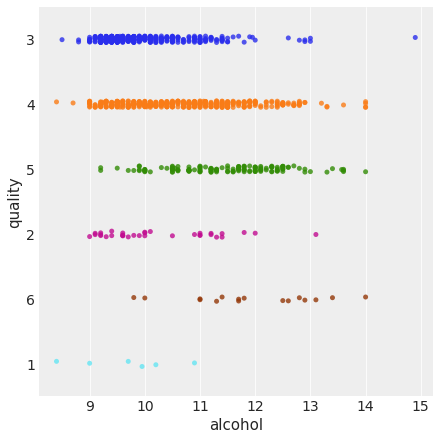

In [ ]:
plt.figure(figsize=(6, 6))
sns.stripplot(x="alcohol", y="quality", data=df, alpha=0.8, jitter=0.05);

And its amounts in these groups.

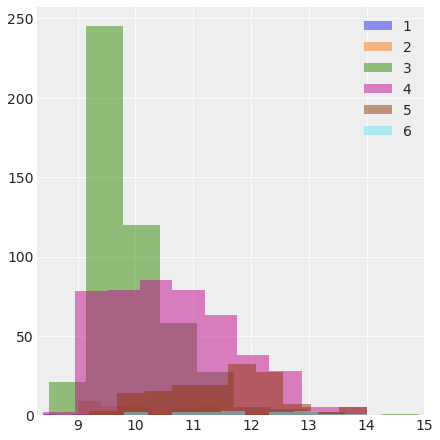

In [ ]:
plt.figure(figsize=(6, 6))
plt.xlim(df.alcohol.min() - 0.1, df.alcohol.max() + 0.1)
for k in range(1, n_classes+1):
    plt.hist(df.alcohol[df.quality==str(k)], 10, alpha=0.5, label=k)
plt.legend();

General information about data: correlations of features and corrmap. Below there is a result of removing correlated features (|correlation| > 0.5).

In [ ]:
df.drop(["fixed acidity", "citric acid", "free sulfur dioxide"], axis = 1).corr()

,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol
volatile acidity,1.000000,-0.005751,0.056336,0.077748,0.016512,0.221492,-0.276079,-0.203909
residual sugar,-0.005751,1.000000,0.070863,0.190790,0.380147,-0.116959,0.017475,0.058421
chlorides,0.056336,0.070863,1.000000,0.048163,0.208901,-0.277759,0.374784,-0.229917
total sulfur dioxide,0.077748,0.190790,0.048163,1.000000,0.050175,-0.059126,0.026894,-0.188165
density,0.016512,0.380147,0.208901,0.050175,1.000000,-0.352775,0.143139,-0.494727
pH,0.221492,-0.116959,-0.277759,-0.059126,-0.352775,1.000000,-0.185499,0.225322
sulphates,-0.276079,0.017475,0.374784,0.026894,0.143139,-0.185499,1.000000,0.094421
alcohol,-0.203909,0.058421,-0.229917,-0.188165,-0.494727,0.225322,0.094421,1.000000


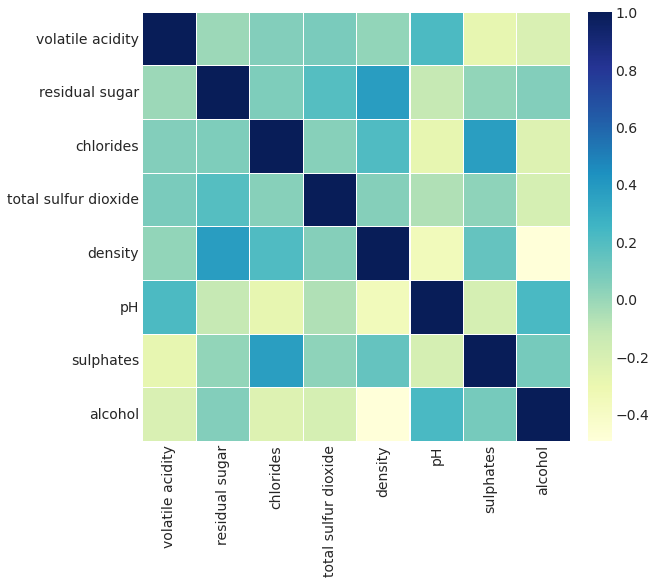

In [ ]:
corrmat = df.drop(["fixed acidity", "citric acid", "free sulfur dioxide"], axis = 1).corr()
  
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [ ]:
X = df.loc[:, df.columns != 'quality']
t = df.quality.astype(int)

#normalization of predictors
x_mean = X.mean()
x_scale = X.std()
X = (X - x_mean )/x_scale

Selecting the most important features for reducing size of training data sample. We will select features with appreciate level of p-value in the standart ordinal logistic model.

In [ ]:
pip install --upgrade --no-deps statsmodels

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [ ]:
mod_log = OrderedModel(t, X, distr='logit')

res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                quality   Log-Likelihood:                -1081.9
Model:                   OrderedModel   AIC:                             2196.
Method:            Maximum Likelihood   BIC:                             2276.
Date:                Thu, 21 Apr 2022                                         
Time:                        12:34:46                                         
No. Observations:                1143                                         
Df Residuals:                    1127                                         
Df Model:                          16                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.2066      0.171      1.208      0.227      -0.129       0.542
volatile acidity        -0.6583      0.086     -7.670      0.000      -0.827      -0.490
citric acid             -0.1381      0.108     -1.280      0.200      -0.349       0.073
residual sugar           0.0991      0.081      1.224      0.221      -0.060       0.258
chlorides               -0.2085      0.077     -2.697      0.007      -0.360      -0.057
free sulfur dioxide      0.0784      0.083      0.945      0.345      -0.084       0.241
total sulfur dioxide    -0.3182      0.091     -3.506      0.000      -0.496      -0.140
density                 -0.1269      0.157     -0.810      0.418      -0.434       0.180
pH                      -0.1356      0.111     -1.218      0.223      -0.354       0.083
sulphates                0.4768      0.073      6.494      0.000       0.333       0.621
alcohol                  0.9396      0.111      8.459      0.000       0.722       1.157
1/2                     -6.1634      0.418    -14.756      0.000      -6.982      -5.345
2/3                      0.6656      0.196      3.398      0.001       0.282       1.050
3/4                      1.3492      0.047     28.451      0.000       1.256       1.442
4/5                      1.0726      0.045     24.039      0.000       0.985       1.160
5/6                      1.0461      0.090     11.626      0.000       0.870       1.223
========================================================================================
"""

In [ ]:
#We keep the most valuable features
X = X[['alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide']]

from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle = True, stratify = t)

MCMC modelling

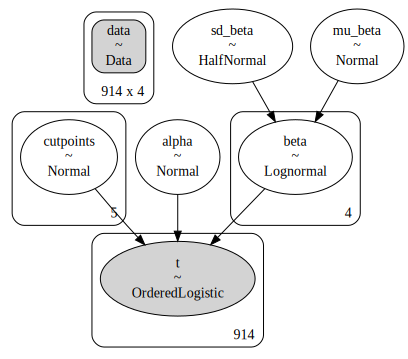

In [ ]:
with pm.Model() as model:
    data = pm.Data("data", X_train)
    cutpoints = pm.Normal("cutpoints", mu=np.arange(1, n_classes) +0.5, sigma=1, 
                          shape=n_classes-1,
                          transform=pm.distributions.transforms.ordered) 
    mu_beta = pm.Normal('mu_beta', mu=0, sigma = 1)    
    sd_beta = pm.HalfNormal('sd_beta', tau =0.7)
    beta = pm.Lognormal('beta', mu=mu_beta, sd=sd_beta, shape = X.shape[1]) 
    alpha = pm.Normal('alpha', mu = 2, sigma = 5)   
    
    eta = alpha + pm.math.dot(X_train, beta)
    outputs = pm.OrderedLogistic("t", eta=eta, cutpoints=cutpoints, observed=t_train-1)

pm.model_to_graphviz(model)

In [ ]:
with model:
    trace = pm.sample(draws=2000, tune=1500, chains=3, cores=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [alpha, beta, sd_beta, mu_beta, cutpoints]


Sampling 3 chains for 1_500 tune and 2_000 draw iterations (4_500 + 6_000 draws total) took 232 seconds.


Let's have a look at trace plots. We can say, that different chains converged to the same distribution.

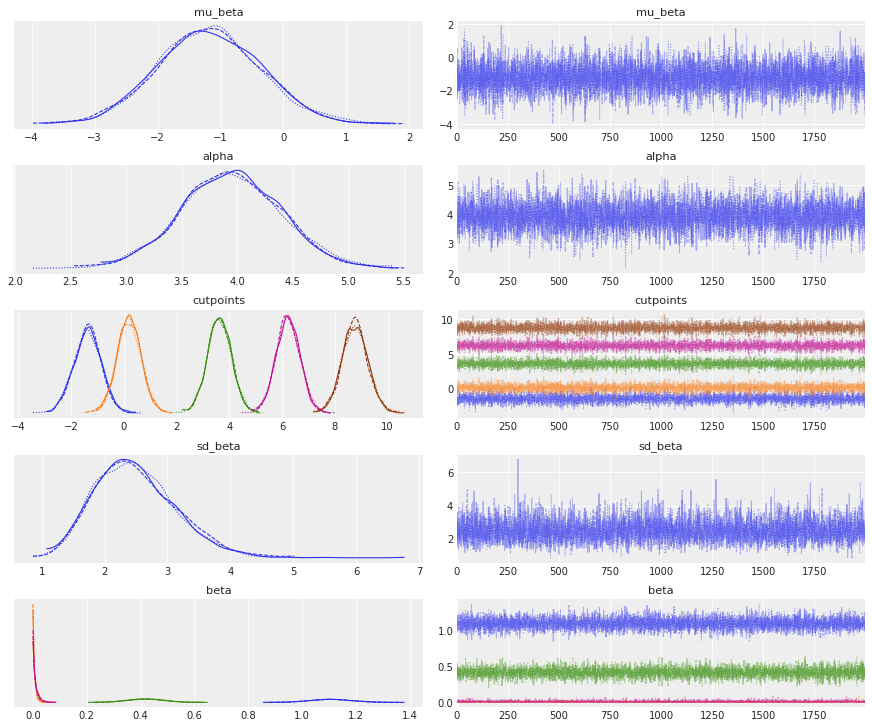

In [ ]:
az.plot_trace(trace);

Plots of ACF also prove the fact that our model is correct, because all of correlations are not significant.

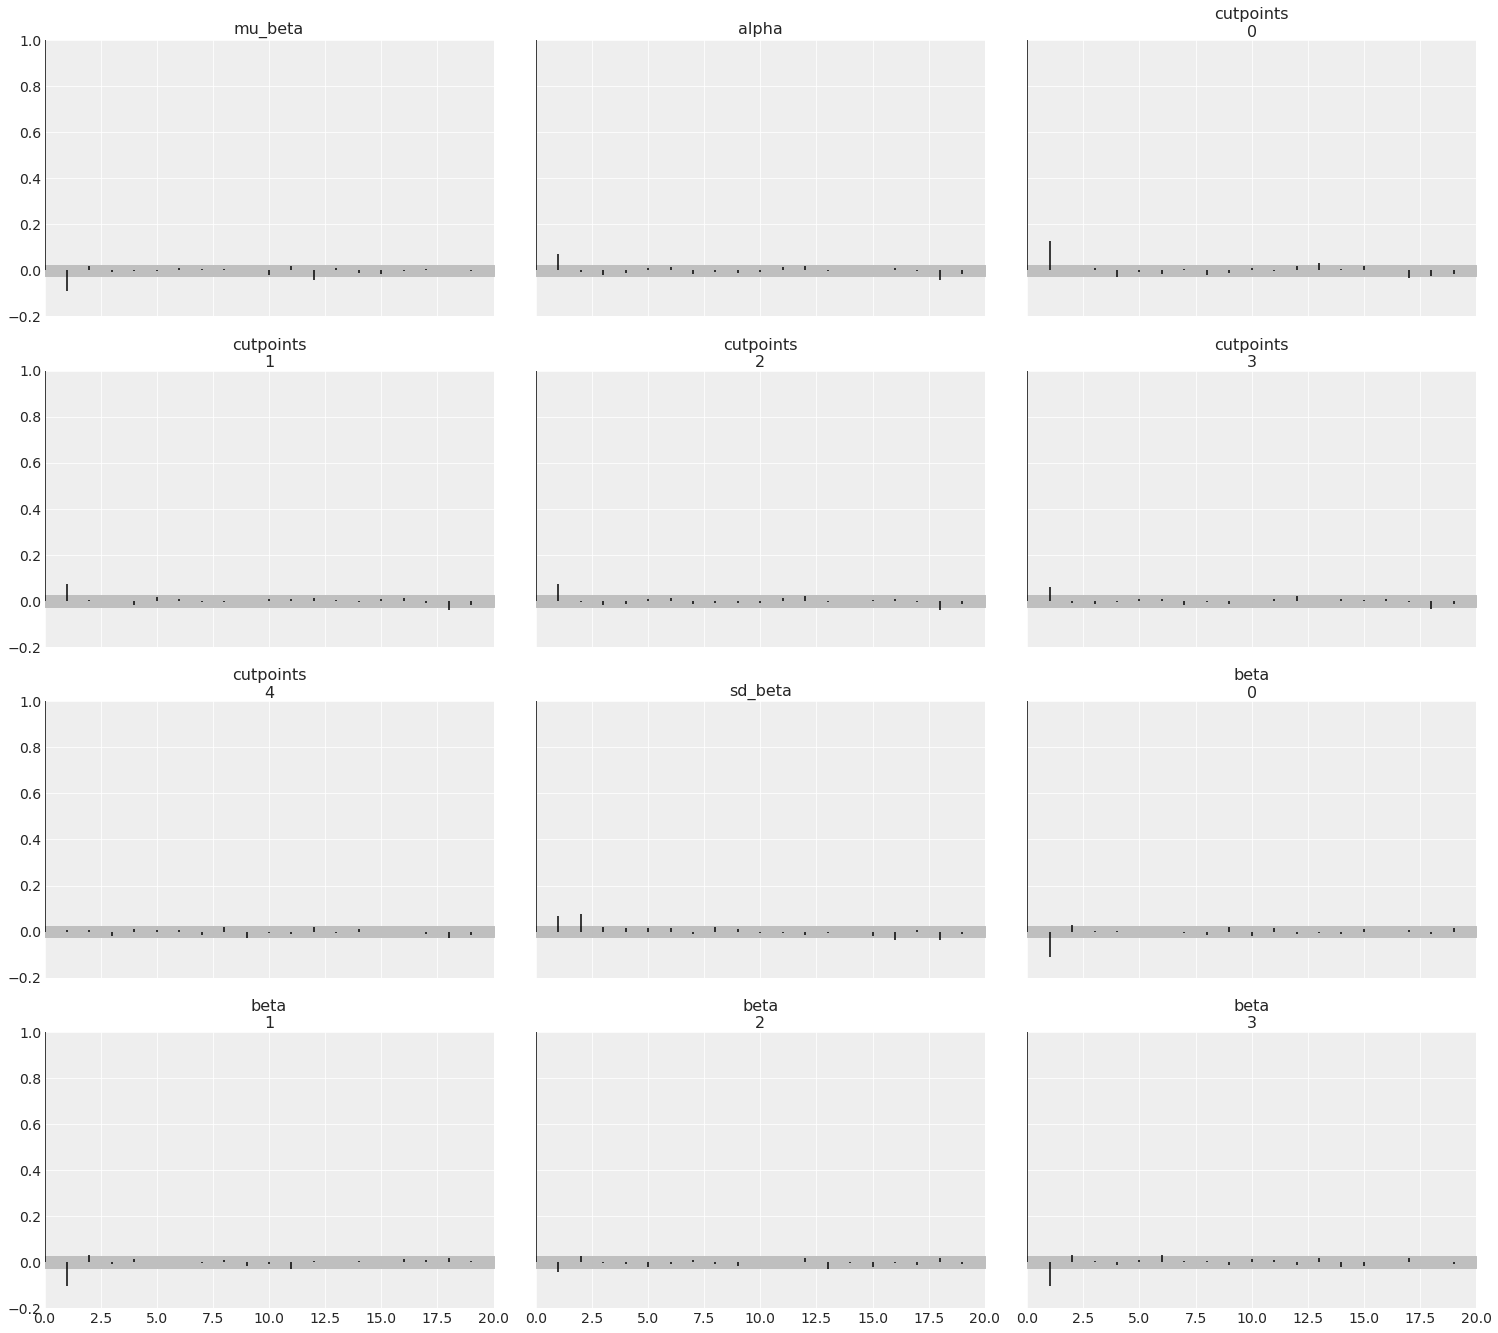

In [ ]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

All r_hats are equal to 1, and it means again the correctness of the model.

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,-1.181,0.814,-2.740,0.303,0.010,0.007,7241.0,3875.0,1.0
alpha,3.943,0.451,3.065,4.758,0.006,0.004,5242.0,4130.0,1.0
cutpoints[0],-1.382,0.521,-2.354,-0.393,0.008,0.006,4694.0,3939.0,1.0
cutpoints[1],0.192,0.461,-0.695,1.061,0.006,0.006,5222.0,3767.0,1.0
cutpoints[2],3.624,0.455,2.731,4.439,0.006,0.004,5228.0,4014.0,1.0
cutpoints[3],6.224,0.455,5.355,7.064,0.006,0.004,5362.0,4408.0,1.0
cutpoints[4],8.761,0.490,7.770,9.638,0.006,0.005,5937.0,4176.0,1.0
sd_beta,2.488,0.641,1.350,3.658,0.010,0.007,4264.0,4230.0,1.0
beta[0],1.106,0.075,0.964,1.247,0.001,0.001,7126.0,4921.0,1.0
beta[1],0.006,0.007,0.000,0.018,0.000,0.000,4172.0,2543.0,1.0


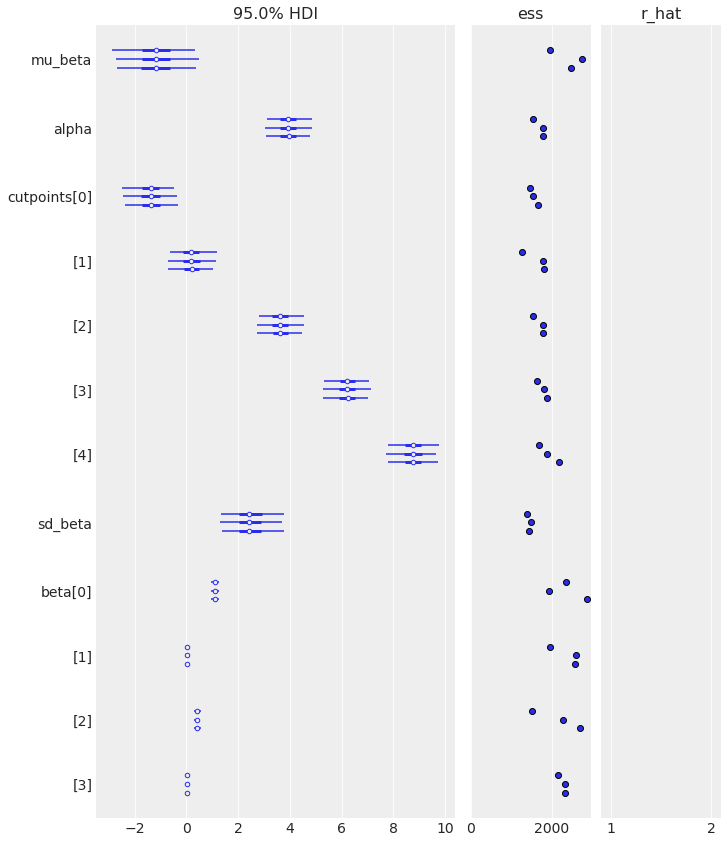

In [ ]:
az.plot_forest(trace, hdi_prob=0.95,
               r_hat=True, ess=True);

Let's compare accuracy of both models.

In [ ]:
mod_log = OrderedModel(t_train, X_train, distr='logit')
res_log = mod_log.fit(method='bfgs')
predicted = res_log.model.predict(res_log.params, X_test)
pred_choice = predicted.argmax(1)
print(f'Accuracy ={(np.asarray(t_test.values) == pred_choice).mean(): 0.3f}')

Optimization terminated successfully.
         Current function value: 0.942715
         Iterations: 33
         Function evaluations: 34
         Gradient evaluations: 34
Accuracy = 0.131


/usr/local/lib/python3.7/dist-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [ ]:
from sklearn.metrics import f1_score
f1_score(np.asarray(t_test.values), pred_choice, average = "micro")

0.13100436681222707

In [ ]:
#Update data reference
pm.set_data({"data": X_test}, model=model)
#Generate posterior samples
ppc_test = pm.sample_posterior_predictive(trace, model=model, samples=len(t_test))

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [ ]:
from scipy import stats
# Compute the point prediction by taking the mode
y_test_pred = stats.mode(ppc_test["t"], axis = 1)[0].flatten()

In [ ]:
from sklearn.metrics import accuracy_score
print(f"Accuracy ={accuracy_score(y_true=t_test, y_pred=y_test_pred): 0.3f}")

Accuracy = 0.214


In [ ]:
f1_score(np.asarray(t_test.values), y_test_pred, average = "micro")

0.21397379912663755

Accuracy is still not so good due the imbalance of class sizes. But it's better than the accuracy of the non-Bayesian model!